# 3. Übung Geodatenanalyse
## Spatial Data Mining II

Das Ziel der heutigen Übung ist es Trajektorien aus GPS-Trackingdaten zu extrahieren und diese anschliessend zu analysieren. Diese Übung knüpft dabei direkt an die letzte Übung an und besteht aus folgenden Teilen: 

- __Teil 1:__ Validierung der Ergebnisse aus Übung 2 (Extrahierung von Aufenthaltspunkten).
- __Teil 2:__ Implementierung eines Algorithmus zur Segmentierung von Trajektorien basierend auf den extrahierten Aufenthaltspunkten. 
- __Teil 3:__ Analyse der Trajektorien mittels Histogrammen, Merkmalberechnung und über ähnlichkeitsbasiertes Clustering
 (Fréchet Distanz).



Click on `Toggle show/hide` to view the imports and some elements for plotting the triplegs later


In [1]:
import os
import time

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

from ipywidgets import HTML
import ipyleaflet as ipy
from ipyleaflet import WidgetControl

from gda_sdm2_functions import read_romataxidata, apply_dbscan, transform, filter_by_label, \
                                get_tripleg_geometry_from_points, get_tripleg, get_ipyleaflet_trackpoint_layer, \
                                hide_toggle
from utils import calculate_distance_matrix

crs_wgs84= "EPSG:4326"

hide_toggle()

In [2]:
# tripleg plotting style
tripleg_style={'opacity': 0.8, 'width': 8, 'color': 'Blue'}
tripleg_hoverstyle={'color': 'Red' , 'fillOpacity': 0.8}

# this defines the box in which tripleg information is displayed (later)
html = HTML("")
html.layout.margin = '0px 20px 20px 20px'
tripleg_info_box = WidgetControl(widget=html, position='topright')

def tripleg_hover_info(feature, **kwargs):
    string_list = []
    string_list.append("<table>")
    for var_name in feature['properties']:
        value = feature['properties'][var_name]
        string_list.append("<tr> <td>{}:</td>  <td>&emsp;</td> <td>{}</td> </tr>\n".format(var_name, value))
   
    string_list.append("</table>")
    html.value = "".join(string_list)

hide_toggle()

## Validierung der Ergebnisse aus Übung 2

### 1.1 Berechnen der Ergebnisse der letzten Übung
Zuerst berechnen wir die Ergebnisse aus Übung 2 erneut. Dafür haben wir die Funktionen, die Sie in Übung 2 bearbeitet haben, in der Datei ``gda_sdm2_functions.py`` zusammengefasst. 


In [3]:
# Path to input file
input_file = os.path.join('input_data', 'taxi_21.txt')

# Read data (nrows can be used to subsample for speed)
data_orginal = read_romataxidata(input_file, nrows=5000) #1700

# Apply transformations
data = transform(data_orginal, timescale=60)

# Calculate clusters with dbscan
labels, core_samples_indices = apply_dbscan(data, eps=5, min_samples=10, metric='chebyshev')

Estimated number of clusters: 47


### 1.2 Staypoints als Geopandas Dataframe
Zunächst visualisieren wir die Daten der letzten Woche, um sie nochmals genauer anzusehen. Dazu fassen wir die Daten in einem [Geopandas Dataframe](https://github.com/geopandas/geopandas) zusammen. Ein Geodataframe ist eine python Datenstruktur, die es uns ermöglicht effizient mit Geodaten umzugehen und sie später zu visualisieren. Alle Daten, die wir visualsieren möchten, müssen also in dem Geodataframe stehen. Um die Ergebnisse gut analysieren zu können und um später mit den Daten weiterarbeiten zu können, brauchen wir vor allem die folgenden Informationen:
- __Geometrie__
- __Zeitstempel__
- __Clusterlabel__ 
- __Kernpunktindikator__

Dafür verbinden wir die Originaldaten (nicht die transformierten Daten, diese haben keine Zeitstempel mehr) mit den Ergebnissen des Cluteringalgorithmus.


In [4]:
# Construct Geodataframe from original data
italy_gdf = gpd.GeoDataFrame(data=data_orginal, columns= ['long', 'lat',  'timestamp'], 
            geometry=gpd.points_from_xy([row[0] for row in data_orginal], [row[1] for row in data_orginal]), crs=crs_wgs84)

# Add clustering information
italy_gdf['is_core'] = False
italy_gdf.loc[core_samples_indices, 'is_core'] = True
italy_gdf['label'] = labels.astype('int')

# make sure the dataframe is sorted by tracking time and show first lines
italy_gdf.sort_values(by='timestamp', inplace=True)

Die nächste Zeile können Sie verwenden, um sich die Daten im Geodataframe etwas genauer anzusehen. Vergewissern Sie sich mit der Funktion `type()`, dass es sich wirklich um ein Geodataframe handelt. Dann versuchen Sie mit der Methode `head()` einen Überblick über die Daten zu gewinnen.

In [5]:
print(type(italy_gdf))
italy_gdf.head()

<class 'geopandas.geodataframe.GeoDataFrame'>


,long,lat,timestamp,geometry,is_core,label
0,12.524926,41.936760,2014-02-02 14:32:17.886734,POINT (12.52493 41.93676),False,-1
1,12.524926,41.936760,2014-02-02 14:32:17.887344,POINT (12.52493 41.93676),False,-1
2,12.523382,41.935415,2014-02-02 14:32:25.942641,POINT (12.52338 41.93541),False,-1
3,12.521539,41.933817,2014-02-02 14:32:40.983523,POINT (12.52154 41.93382),False,-1
4,12.521023,41.933368,2014-02-02 14:32:56.936338,POINT (12.52102 41.93337),False,-1


Die Daten im Geopandasformat geben uns schon jetzt die Möglichkeit sie einfach und schnell über die `gdf.plot()` zu visualisieren.

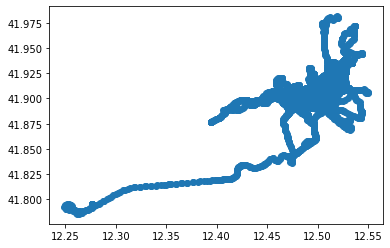

In [6]:
italy_gdf.plot()

### 1.3 Interaktive Visualisierung von Staypoints
Um die Ergbnisse gut zu verstehen, ist es hilfreich, sie interaktiv auf einer Karte darzustellen. Dafür verwenden wir die Bibliothek [ipyleaflet](https://github.com/jupyter-widgets/ipyleaflet), die es ermöglicht mit Python auf die Funktionen der Java library [leaflet](https://leafletjs.com/) zugzugreifen um Geodaten interaktiv in Jupyter Notebooks darzustellen. Wenn Sie möchten, können Sie auch verschiedene [basemaps](https://ipyleaflet.readthedocs.io/en/latest/api_reference/basemaps.html) ausprobieren 
Zuerst initialisieren wir die Karte:

In [7]:
m = ipy.Map(center=(41.888, 12.5215), zoom = 12, basemap=ipy.basemaps.OpenStreetMap.Mapnik)
m

Map(center=[41.888, 12.5215], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoo…

Jetzt verwenden wir die fertige Funktion `get_ipyleaflet_trackpoint_layer` um ipyleaflet Layer zu erzeugen, die wir anzeigen können. Diese Funktion erzeugt viele [CircleMarker](https://ipyleaflet.readthedocs.io/en/latest/api_reference/circle_marker.html) Objekte und gibt ihnen verschiedene Farben in Abhängigkeit von ihrem Cluster. Die Funktion `get_ipyleaflet_trackpoint_layer` gibt zwei Layerobjekte zurück, die wir über die `add_layer` Funktion des ipyleaflet [`Map`](https://ipyleaflet.readthedocs.io/en/latest/api_reference/map.html) Objekts anzeigen lassen können. 

Über die Parameter der Funktion können wir einstellen wie viele Trackpoints wir anzeigen wollen, um die Geschwindigkeit zu verbessern. `slack` gibt dabei an, wie viele Punkte vor und nach dem min/max Label wir noch anzeigen wollen.
Mit `ipy.LayersControl()`(https://ipyleaflet.readthedocs.io/en/latest/api_reference/layers_control.html) können wir schliesslich noch ein Widget anzeigen lassen, dass es uns erlaubt die einzelnen Layer zu steuern.

In [8]:
layer_noise, layer_sp = get_ipyleaflet_trackpoint_layer(italy_gdf.copy(), min_label=6, max_label=8, slack=10)
m.add_layer(layer_noise)
m.add_layer(layer_sp)
m.add_control(ipy.LayersControl())

Sehen Sie sich die Interaktive Karte an, sehen die Ergebnisse sinvoll aus? Die einzelnen Trackpunkte sind in Grau eingezeichnet, Staypoints (Punkte die zu einem Cluster gehören) sind etwas grösser in Farbe eingezeichnet.
Wenn die Karte nichts anzeigt, dann muss der Code eventuell nochmal ausgeführt werden. 

## Teil 2: Segmentierung von Triplegs

Nachdem wir die Staypoints aus den Trackpoints herausgerechnet haben, interessieren wir uns für die Bewegungstrajektorien. Eine einfache Möglichkeit, um Trajektorien zu definieren ist, alle nicht-Staypoint Trackpunkte zwischen zwei Staypoints einer Bewegungstrajektorie zuzuordnen. 

Die dahinterstehende Annahme ist einfach: Wenn wir nicht stehen, dann bewegen wir uns. 

Dieses Beispiel können wir uns nochmals auf der Karte ansehen. Dort ist zu erkennen, dass wir eine Bewegungstrajektorie definieren können, indem wir alle grauen Punkte zwischen zwei Haltepunkten zu einer Trajektorie zusammenfassen. 

In [ ]:
m_trackpoints = ipy.Map(center=(41.888, 12.5215), zoom = 12) # basemap= ipy.basemaps.Esri.WorldTopoMap)
layer_noise_67, layer_sp_67 = get_ipyleaflet_trackpoint_layer(italy_gdf.loc[812:942].copy(), filter_gdf=False)
m_trackpoints.add_layer(layer_noise_67)
m_trackpoints.add_layer(layer_sp_67)
m_trackpoints

Die Idee des Algorithmus wird deutlich, wenn wir uns einen Ausschnitt der Daten ansehen. Wenn Sie von oben nach unten, Zeile für Zeile durchgehen. Dann beginnt unsere Bewegungstrajektorie sobald wir von `label=6` auf `label=-1` wechseln. Sobald wir von `label=-1` auf `label=7` wechseln, endet die Bewegungstrajektorie und der nächste Aufenthaltspunkt beginnt. Alle Punkte dazwischen gehören zu einer Bewegungstrajektorie. Wenn die Spalte `label` von `7` auf `-1` wechselt, dann beginnt die nächste Bewegungstrajektorie.

In [ ]:
pd.set_option('display.max_rows', 1000)
italy_gdf.loc[812:950,['timestamp', 'label', 'geometry']]

### Teil 2.1 Implementierung des Algorithmus
Um den Algorithmus zu implementieren erstellen wir eine Liste. Hier eine Übersicht über die wichtigsten Operationen:
- ```trackpoint_list[0]``` gibt Ihnen die erste Zeile der Liste an Trackpoints zurück.
- Eine Zeile der Trackpoints hat 3 Spalten (genau wie oben dargestellt), die auch wieder in einer Liste zusammengefasst sind. Die Operation ```trackpoint_list[0][1]``` gibt Ihnen zum Beispiel das zweite Element der ersten Zeile zurück (in dem Fall das Label).
- Für die Umsetzung benötigen Sie zwei Schleifen. Die erste geht die Liste entlang bis `label=-1`. Dann startet die zweite Schleife bis `label != -1`.
- Alle Punkte die in der zweiten Schleife überschritten werden, sollen in der Liste `tripleg_point_list` gespeichert werden. 
- Die Funktion `get_tripleg_geometry_from_points` transformiert eine Liste mit Punkten in eine Liniengeometrie (z.B. `tripleg_point_list`). 
- Am Ende der zweiten Schleife sollen alle Tripleginformationen als Tuple (oder Liste) mit `append` an die Liste `tripleg_list` angehängt werden.
- Vergessen Sie nicht die Laufparameter an den richtigen Stellen zu inkrementieren, damit Sie nicht in einer unendlichen while-Schleife feststecken. 
- Vergessen Sie nicht am Ende der zweiten Schleife, den Laufparameter der ersten Schleifen so zu erhöhen, dass er am Ende des Triplegs steht. 
- Nutzen Sie `while` Schleifen um den Laufparameter (z.B. i oder j) in der Schleife zu verändern.


#### Datenmodell Triplegs
Für jedes Tripleg sollen die folgenden Informationen gespeichert werden:
- previous label: Das Label des vorherigen Staypoints
- next label: Das Label des nächsten Staypoints
- start time: Der Zeitstempel des ersten Trackpoints, der dem Tripleg zugerechnet wird
- end time: Der Zeitstempel des letzten Trackpoints, der dem Tripleg zugerechnet wird
- geometry: Shapely linestring geometry

Die Daten müssen in genau dieser Reihenfolge in einem Container (z.B. Tuple oder Liste) an die Liste `tripleg_list` angehängt werden.


In [ ]:
trackpoint_list = italy_gdf[['timestamp', 'label', 'geometry']].values.tolist()

In [ ]:
# initialize
n = len(trackpoint_list)
tripleg_list = []
i = 0

# iterate all trackpoints
while (i < (n-1)):

    # check if new tripleg begins
    if trackpoint_list[i][1] == -1:
        
        
        # store information from tripleg start
        tripleg_previouslabel = trackpoint_list[i-1][1]
        tripleg_starttime = trackpoint_list[i][0]
        tripleg_point_list = []
        
        # iterate from start of tripleg until end of tripleg
        j = i
        while j < (n -1) and trackpoint_list[j][1] == -1: 
        
            # store trackpoints of tripleg
            tripleg_point_list.append(trackpoint_list[j][2])
            j +=1
                    
        # end of tripleg
        
        # if we have at least 2 points in the tripleg_point_list, we store the tripleg 
        if len(tripleg_point_list) > 2:
        
            # collect tripleg information rember, j is now pointing on a staypoint and therefore on a non-tripleg point 
            tripleg_geometry = get_tripleg_geometry_from_points(tripleg_point_list)
            tripleg_nextlabel = trackpoint_list[j][1]
            tripleg_endtime = trackpoint_list[j-1][0]

            # append tripleg information (as tuple or list) to the 'tripleg_list'.
            # The order has to be (tripleg_previous_label, tripleg_nextlabel, tripleg_starttime, tripleg_endtime, tripleg_geometry)
            tripleg_list.append((tripleg_previouslabel, tripleg_nextlabel, tripleg_starttime, tripleg_endtime, tripleg_geometry))
        
        # set i counter to the next point non-tripleg point
        i = j
        

                
    else:
        i +=1           

Tests?

### 2.2 Visualisierung der Ergebnisse:
Um die Ergebnisse zu visualisieren, definieren wir die Daten wieder als Geopandas Geodataframe.

In [ ]:
# transform data into a geodataframe. 'tripleg_list' has to be a list of tuples e.g.,
#(cluster_start, cluster_end, start_time, end_time, geometry) or a list of lists with the same order of items
tripleg_gdf = pd.DataFrame(tripleg_list, columns=['prevlabel', 'nextlabel', 'start_time', 'end_time', 'geometry'])
tripleg_gdf = gpd.GeoDataFrame(tripleg_gdf, geometry=tripleg_gdf.geometry, crs=crs_wgs84)

# transform timestamps to strings for plotting
tripleg_gdf['start_time'] = tripleg_gdf['start_time'].dt.strftime("%Y-%m-%d %H:%M:%S")
tripleg_gdf['end_time'] = tripleg_gdf['end_time'].dt.strftime("%Y-%m-%d %H:%M:%S")

Initialisierung der Karte mit Trackpoints

In [ ]:
m = ipy.Map(center=(41.8881987655463, 12.5215863435528), zoom = 12) # basemap= ipy.basemaps.Esri.WorldTopoMap)
min_label = 6
max_label = 8
m.add_control(ipy.LayersControl())
m.add_control(tripleg_info_box)
m.add_layer(layer_noise)
m.add_layer(layer_sp)
m

Einzeichnen der Triplegs: Sind die Ergebnisse sinnvoll? Fahren Sie mit dem Mauszeiger auf ein Tripleg um die darin gespeicherten Informationen zu sehen.

In [ ]:
# add one tripleg
#geo_data = ipy.GeoData(geo_dataframe=tripleg_gdf[tripleg_gdf['prevlabel']==19], name='triplegs', style=tripleg_style, hover_style=tripleg_hoverstyle)

# add a range of triplegs (recommended)
#tripleg_gdf_filtered = filter_by_label(tripleg_gdf, min_label, max_label, label_col_name='prevlabel')
#geo_data = ipy.GeoData(geo_dataframe=tripleg_gdf_filtered, name='triplegs', style=tripleg_style, hover_style=tripleg_hoverstyle)

# add all triplegs
geo_data = ipy.GeoData(geo_dataframe=tripleg_gdf, name='triplegs', style=tripleg_style, hover_style=tripleg_hoverstyle)

geo_data.on_hover(tripleg_hover_info)
m.add_layer(geo_data)


Es ist ausserdem hilfreich für das bessere Verständnis, sich die Daten auch als Text anzusehen: 

In [ ]:
tripleg_gdf

## Teil 3: Analyse der Triplegs
Sobald wir Triplegs definiert haben, können wir sie weiter analysieren.

### 3.1 Analyse der eigenschaften (Geschwindigkeit, Länge, Dauer)
Für eine Analyse ist es interessant, sich die Verteilung der Geschwindigkeit, der Länge und der Dauer von Triplegs genauer anzusehen. Dafür müssen wir die Daten wieder in ein projeziertes Koordinatensystem überführen.

Hier einige Hinweise zum Vorgehen: 


Projezieren Sie die Daten nach [EPSG:25833](https://epsg.io/25833). Mit Geopandas kann diese Aufgabe mit nur einer Zeile Code gelöst werden. [Beispiele](https://geopandas.org/projections.html)

In [ ]:
tripleg_gdf_2d = tripleg_gdf.to_crs("EPSG:25833")

### Länge
Berechnen Sie nun zuerst die Länge der Triplegs. Beachten Sie, dass die Geometrien als [Shapely](https://shapely.readthedocs.io/en/latest/manual.html#linestrings) Objekte gespeichert sind. Dies erlaubt es Ihnen zum Beispiel, die Länge des ersten Objekts in einem Geodataframe folgendermassen zu erhalten: `gdf.iloc[0].geometry.length`.

Speichern Sie die Längen aller Triplegs in einer neuen Spalte in dem Geodataframe, in einem Numpyarray oder einer Liste. Verwenden Sie die Funktion `plt.hist` von [Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.hist.html) um ein Histogram zu plotten.

Beachten Sie, dass die Einheit der Koordinaten in Meter ist. Für die Interpretation ist es einfacher, wenn Sie die Längenverteilung in Kilometern angeben.

In [ ]:
tripleg_gdf_2d['length'] = tripleg_gdf_2d.apply(lambda x: x.geometry.length, axis=1)

In [ ]:
(tripleg_gdf_2d['length']/1000).hist(bins=20)
plt.title('length in km')

### Dauer
Berechnen Sie als nächstes die Dauer für die einzelnen triplegs. Beachten Sie, dass die Daten im Augenblick noch als `string` im Geodataframe gespeichert sind.
- Verwenden Sie die zum Beispiel die pandas Funktion [`to_datetime`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html), um den Zeitstempel wieder in ein maschinenlesbares Format (=Python Datetime) umzuwandeln.
- Python Datetime Zeitstempel können Sie einfach voneinander abziehen um die Dauer zu erhalten. Sie erhalten dann ein [`timedelta`](https://docs.python.org/2/library/datetime.html#timedelta-objects) Objekt.
- Plotten Sie die Dauerverteilung in Minuten als Histogramm.

In [ ]:
tripleg_gdf_2d['start_time'] = pd.to_datetime(tripleg_gdf_2d['start_time'], format="%Y-%m-%d %H:%M:%S")
tripleg_gdf_2d['end_time'] = pd.to_datetime(tripleg_gdf_2d['end_time'], format="%Y-%m-%d %H:%M:%S")
tripleg_gdf_2d['duration'] = tripleg_gdf_2d['end_time'] - tripleg_gdf_2d['start_time']

In [ ]:
(tripleg_gdf_2d['duration'].dt.total_seconds()/60).hist(bins=20)
plt.title('duration in minutes')

### Geschwindigkeit
Berechnen Sie jetzt die Geschwindigkeit in km/h. Beachten Sie, dass es Triplegs mit einer Dauer nahe 0 geben kann. Das heisst Sie müssen diese gegebenenfalls vor der Division filtern.

In [ ]:
tripleg_gdf_2d['speed'] = (tripleg_gdf_2d['length']/1000)/ (tripleg_gdf_2d['duration'].dt.seconds/3600)
tripleg_gdf_2d.replace([np.inf, -np.inf], np.nan, inplace=True)

In [ ]:
tripleg_gdf_2d['speed'].dropna().hist()
plt.title('speed')

Sind die Ergebnisse sinnvoll? Diese Diagramme helfen Ihnen zum einen herauszufinden ob es vielleicht einen Fehler in dem Algorithmus gibt aber auch um herauszufinden ob die Daten so in Ordnung sind. 

__Bonusaufgabe:__ Analysieren Sie das Tripleg mit prevlabel=19 und prevlabel=20. Was fällt Ihnen auf und warum ist dieses Tripleg so seltsam? Tipp: Sie müssen dafür die Trackpoints in dem folgenden Indexbereich laden: `2520-3000`

###  3.2 Clustering über Distanzmetrik (Fréchet)
Ein wichtiges Problem in der Bewegungsdatenanalyse ist es, (geometrisch) ähnliche Trajektorien zu identifizieren. Dieses Problem ist kompliziert, da Trajektorien hochdimensional und unstrukturiert sind. Es ist zum Beispiel möglich, dass Sie die Geometrie zweier Trajektorien vergleichen möchten, die unterschiedliche sampling frequenzen und dadurch bedingt eine unterschiedliche Anzahl an Stüzpunkten haben.

Eine Lösung für dieses Problem wird durch Distanzmetriken gegeben. Diese definieren ein Mass für die Geometrische ähnlichkeit zweier Trajektorien da und representieren die Ähnlichkeit zweier Trajektorien über einen einzelnen Distanzwert.
Nutzen Sie die Funktion `calculate_distance_matrix` und übergeben Sie Ihr ein Geodataframe mit Trajektorien um eine Distanzmatrix zu erhalten.

__Achtung!__ Die Funktion `calculate_distance_matrix` berechnet die paarweisen Distanzen zwischen allen Triplegs. Damit Beträgt die Anzahl der Berechnungen $\frac{(n-1)^2}{2}$ und steigt damit quadratisch mit der Anzahl der Berechnungen. Gleichzeitig ist die Berechnung der Fréchetdistanz sehr Rechenaufwändig. Fangen Sie deshalb mit der Berechnung von wenigen Trajektorien (zum Beispiel 5) an und erhöhen Sie die Anzahl der Trajektorien später.

In [ ]:
tripleg_gdf_2d_red = tripleg_gdf_2d.iloc[0:15,:].copy()
D_frechet = calculate_distance_matrix(tripleg_gdf_2d_red, distance='frechet')

### Visualisieren der Distanzmatrix
Verwenden Sie die Funktion [`imshow`](https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.imshow.html) von Matplotlib um die Distanzmatrix zu visualisieren. Lassen Sie sich ausserdem eine `colorbar` anzeigen und wählen Sie eine geeignete Colormap. Zum Beispiel `jet`

In [ ]:
plt.imshow(D_frechet, cmap='jet')
plt.colorbar()
np.max(D_frechet)

Können Sie Cluster in der Distanzmatrix erkennen?

### Clustering
Es ist sehr schwer Cluster zuverlässig aus der Distanzmatrix herauszulesen. Es ist allerdings Möglich die Distanzmatrix direkt aus Eingagsdaten für einen Clusteringalgorithmus zu verwenden.
- Verwenden Sie [`KMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) aus der Scikit-learn Bibliothek, um die Trajektorien basierend auf der Distanzmatrix zu clustern
- Definieren Sie die Label als eine neue Spalte in dem Geodataframe. Sie können über die Eigenschaft `labels_` auf die Informationen zugreifen.
- Stellen Sie das Ergebnis mithilfe der [`plot`](https://geopandas.org/mapping.html#choosing-colors) Funktion des Geodataframes da. Über das Schlüsselwort `column` können Sie festlegen, über welche Spalte die einzelnen Trajektorien eingefärbt werden sollen.
- Stellen Sie sicher, dass die Grafik ausreichend gross ist. Dafür können Sie der `plot` Funktion, das Schlüsselwort `figsize=(12,12)` übergeben.
- Die Wahl der Anzahl an Cluster bei KMeans ist ein komplizierts Problem. Probieren Sie verschiedene Werte aus und beobachten Sie wie sich das Ergebnis dabei verändert.


In [ ]:
km = KMeans(n_clusters=4).fit(D_frechet)
km.labels_

In [ ]:
tripleg_gdf_2d_red['tripleg_cluster'] = km.labels_

In [ ]:
tripleg_gdf_2d_red.plot(column='tripleg_cluster', figsize=(12,12))